# I. Definition

## Project Overiview

The Programme for International Student Assessment (PISA) is a worldwide study of 15-year-old school pupils' scholastic performance on mathematics, science, and reading.

In this project, we will predict the reading scores of students using the background information such as parents education, school size, using computer for homework, etc., provided by student and the School. We use PISA 2009 dataset as reading literacy was the main domain assessed in 2009.


## Problem Statement

The goal is to train a model to predict the reading score of student using their demographical information. Since this is a problem of supervised learning of type regression. Several regression algorithms will be explored, as discussed in Phase II, Analysis.

## Metrics

We will use two metrics:
* RMSE(Root Mean Squared Error)
* R^2(R-squared)

# II. Analysis

In [249]:
# import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import timeit

# Use average of scores as benchmark
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn import model_selection


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit


from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor


## Data Exploration

### Load the dataset

In [250]:
pisa = pd.read_csv('pisa2009.csv')
print('Shape of dataset: ',pisa.shape)

('Shape of dataset: ', (5233, 24))


## Exploratory Visualization

In [251]:
pisa.dtypes

grade                      int64
male                       int64
raceeth                   object
preschool                float64
expectBachelors          float64
motherHS                 float64
motherBachelors          float64
motherWork               float64
fatherHS                 float64
fatherBachelors          float64
fatherWork               float64
selfBornUS               float64
motherBornUS             float64
fatherBornUS             float64
englishAtHome            float64
computerForSchoolwork    float64
read30MinsADay           float64
minutesPerWeekEnglish    float64
studentsInEnglish        float64
schoolHasLibrary         float64
publicSchool               int64
urban                      int64
schoolSize               float64
readingScore             float64
dtype: object

In [252]:
pisa.head()

,grade,male,raceeth,preschool,expectBachelors,motherHS,motherBachelors,motherWork,fatherHS,fatherBachelors,...,englishAtHome,computerForSchoolwork,read30MinsADay,minutesPerWeekEnglish,studentsInEnglish,schoolHasLibrary,publicSchool,urban,schoolSize,readingScore
0,11,1,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,...,0.0,1.0,0.0,225.0,NaN,1.0,1,1,673.0,476.00
1,11,1,White,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,450.0,25.0,1.0,1,0,1173.0,575.01
2,9,1,White,1.0,1.0,1.0,1.0,1.0,1.0,NaN,...,1.0,1.0,0.0,250.0,28.0,1.0,1,0,1233.0,554.81
3,10,0,Black,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,200.0,23.0,1.0,1,1,2640.0,458.11
4,10,1,Hispanic,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,250.0,35.0,1.0,1,1,1095.0,613.89


### Missing Values

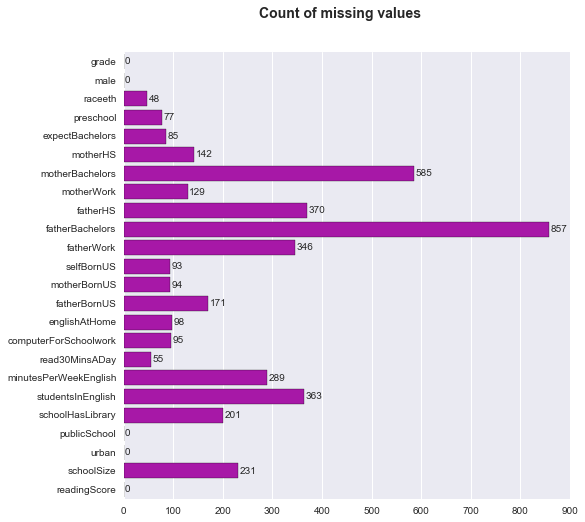

In [253]:
fig = plt.figure(figsize=(8, 8))
fig.suptitle('Count of missing values', fontsize=14, fontweight='bold')
null_data = pisa.isnull().sum()
ax = sns.barplot(x = null_data.values, y=null_data.index, color="m" )
i = 0
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 3, p.get_y() + 0.5, null_data.values[i])
    i += 1

In [254]:
# Continuous Features
contFeatures = ['minutesPerWeekEnglish','studentsInEnglish','schoolSize']
pisa[contFeatures].describe()

,minutesPerWeekEnglish,studentsInEnglish,schoolSize
count,4944.000000,4870.000000,5002.000000
mean,265.717840,24.559754,1374.367653
std,149.591118,7.139661,870.424790
min,0.000000,1.000000,100.000000
25%,225.000000,20.000000,712.000000
50%,250.000000,25.000000,1233.000000
75%,300.000000,30.000000,1900.000000
max,2400.000000,90.000000,6694.000000


The max value of * minutesPerWeekEnglish * is very fary from the 75th percentile

### Outliers

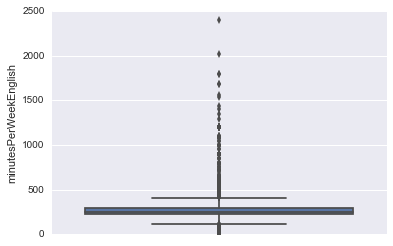

In [255]:
sns.boxplot(y=pisa["minutesPerWeekEnglish"])

In [256]:
pisa['minutesPerWeekEnglish'].describe()

count    4944.000000
mean      265.717840
std       149.591118
min         0.000000
25%       225.000000
50%       250.000000
75%       300.000000
max      2400.000000
Name: minutesPerWeekEnglish, dtype: float64

The boxplot confirms the outlier.  The max value is 2400 minutes (40 hours) per week of English classes. It's not normal as students has other classes to attend.

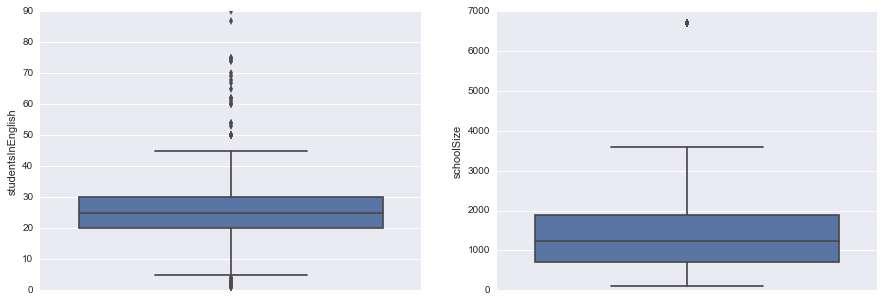

In [257]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

sns.boxplot(y= pisa["studentsInEnglish"], ax=ax[0])
sns.boxplot(y= pisa["schoolSize"], ax=ax[1])

For 'studentsInEnglish' and 'schoolSize', the outliers are not a big  concern here as both min and max values are in acceptable range for the number of students in the class and school.

### Bivariate plots on continuous predictors

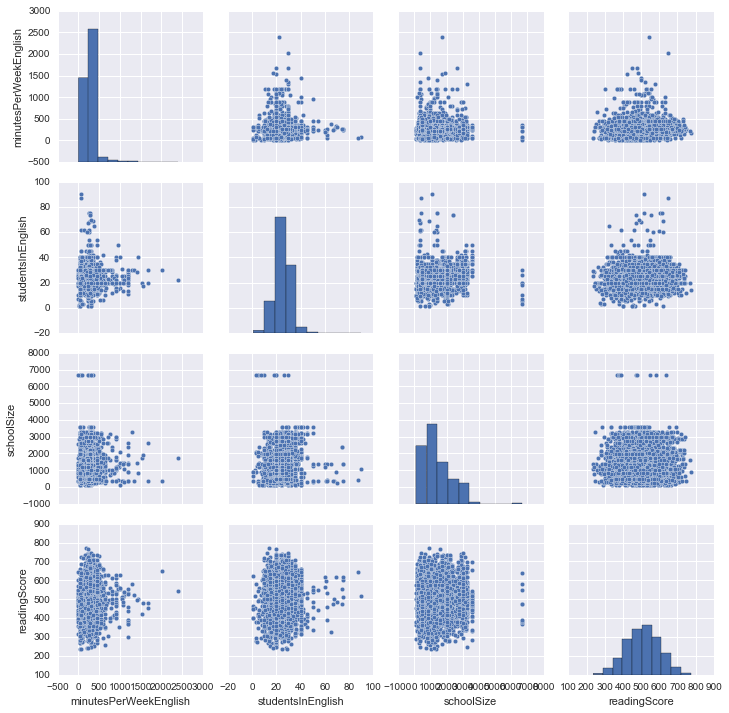

In [258]:
_ = sns.pairplot(pisa[contFeatures + ['readingScore']].dropna())

In [259]:
pisa.minutesPerWeekEnglish.describe()

count    4944.000000
mean      265.717840
std       149.591118
min         0.000000
25%       225.000000
50%       250.000000
75%       300.000000
max      2400.000000
Name: minutesPerWeekEnglish, dtype: float64

### Correlation

In [260]:
from IPython.display import display
tempdf = pisa.copy()

raceeth = pd.get_dummies(tempdf['raceeth'], 'r')
tempdf = pd.concat([tempdf, raceeth], axis=1)
tempdf = tempdf.drop('raceeth', axis=1)

#move the prediction target towards the end
tempdf = tempdf.drop('readingScore', axis=1)
tempdf['readingScore'] = pisa['readingScore']

raceeth
corr = tempdf.corr(method='pearson')
with pd.option_context('display.max_columns', None):
    display(corr)

,grade,male,preschool,expectBachelors,motherHS,motherBachelors,motherWork,fatherHS,fatherBachelors,fatherWork,selfBornUS,motherBornUS,fatherBornUS,englishAtHome,computerForSchoolwork,read30MinsADay,minutesPerWeekEnglish,studentsInEnglish,schoolHasLibrary,publicSchool,urban,schoolSize,r_American Indian/Alaska Native,r_Asian,r_Black,r_Hispanic,r_More than one race,r_Native Hawaiian/Other Pacific Islander,r_White,readingScore
grade,1.000000,-0.089213,-0.011200,0.148041,0.028976,0.043972,0.042522,0.068751,0.056805,0.010012,-0.015076,-0.062865,-0.057618,-0.009583,0.105568,0.065484,0.045747,0.074487,-0.016703,-0.059306,0.080561,0.063289,-0.023408,0.084707,-0.033769,-0.013163,-0.005996,0.029203,0.004317,0.272413
male,-0.089213,1.000000,0.005507,-0.088671,0.031166,0.048206,-0.016717,0.016752,0.057838,0.030472,0.013215,0.002977,0.012652,-0.005748,-0.028993,-0.214101,0.009808,-0.036348,0.022453,-0.075265,0.016113,-0.004586,0.022623,-0.023206,-0.010602,0.015579,-0.008216,0.019584,-0.000760,-0.145303
preschool,-0.011200,0.005507,1.000000,0.095978,0.140893,0.154680,0.069062,0.137600,0.146597,0.054756,0.093149,0.110534,0.113289,0.122812,0.094145,-0.003884,-0.012829,-0.030150,0.029039,-0.076767,-0.056366,-0.024381,-0.002954,-0.001570,0.039726,-0.120714,0.000731,-0.001656,0.077568,0.060373
expectBachelors,0.148041,-0.088671,0.095978,1.000000,0.109735,0.174178,0.070219,0.151738,0.208115,0.023476,-0.002508,0.009766,0.009201,0.035530,0.132233,0.125497,0.008403,0.041987,0.055405,-0.113289,0.006144,0.021538,-0.032191,0.062091,-0.008816,-0.088334,-0.000554,0.003074,0.064732,0.359425
motherHS,0.028976,0.031166,0.140893,0.109735,1.000000,0.252665,0.170211,0.509090,0.229883,0.036855,0.176047,0.344936,0.337395,0.376071,0.182245,0.020236,0.031403,-0.042705,0.021296,-0.074333,-0.116650,-0.089987,-0.004978,-0.044241,0.062062,-0.348739,0.024971,0.006369,0.260682,0.161376
motherBachelors,0.043972,0.048206,0.154680,0.174178,0.252665,1.000000,0.133704,0.210307,0.539321,0.067062,0.028062,0.140357,0.119619,0.160095,0.144212,0.033012,0.017249,-0.043409,0.022864,-0.172575,-0.040708,-0.007501,-0.023187,0.010866,-0.000595,-0.206743,0.007320,-0.006831,0.173525,0.213743
motherWork,0.042522,-0.016717,0.069062,0.070219,0.170211,0.133704,1.000000,0.115492,0.046268,0.054015,0.067138,0.102452,0.094600,0.121524,0.091743,-0.027740,0.022426,-0.011111,-0.007515,-0.025414,-0.027873,-0.047528,-0.021544,-0.025607,0.041216,-0.102118,0.013330,-0.005968,0.071580,0.047248
fatherHS,0.068751,0.016752,0.137600,0.151738,0.509090,0.210307,0.115492,1.000000,0.281755,0.107036,0.150403,0.298765,0.320266,0.336876,0.170892,0.046933,0.036223,-0.020973,0.036179,-0.086946,-0.100400,-0.083902,-0.018314,0.017634,0.044931,-0.339347,0.019806,0.017167,0.241250,0.188446
fatherBachelors,0.056805,0.057838,0.146597,0.208115,0.229883,0.539321,0.046268,0.281755,1.000000,0.108559,-0.008772,0.068955,0.072586,0.125238,0.172355,0.057101,0.008416,-0.031457,0.006428,-0.188413,-0.007594,0.031286,-0.044834,0.072559,-0.062323,-0.202203,-0.012158,-0.011727,0.192768,0.260840
fatherWork,0.010012,0.030472,0.054756,0.023476,0.036855,0.067062,0.054015,0.107036,0.108559,1.000000,-0.024228,-0.004170,-0.007727,0.013639,0.083243,-0.012241,0.023599,0.003508,-0.003134,-0.020203,-0.029030,-0.022164,-0.042797,-0.010644,-0.095892,-0.020836,-0.014122,-0.033243,0.102633,0.067909


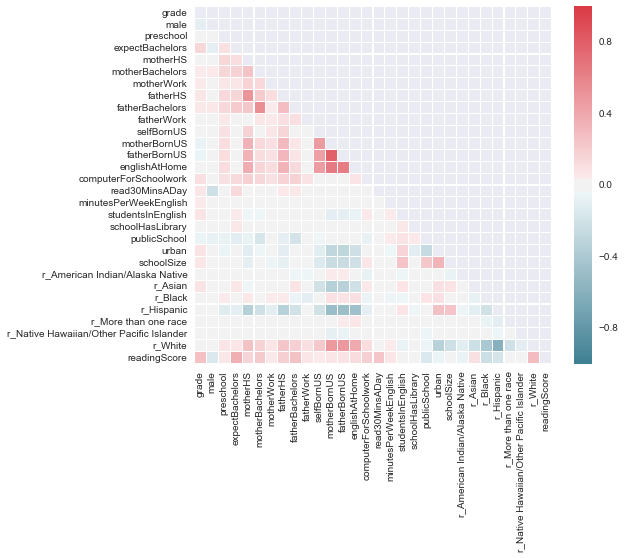

In [261]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# # Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))
#
# # Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#
# # Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,vmax=1,
            square=True,linewidths=.1, cbar_kws={"shrink": .8}, ax=ax)
plt.show()

In [262]:
cor_dict = corr['readingScore'].to_dict()
del cor_dict['readingScore']
print("List the numerical features decendingly by their correlation with Reading Score:\n")
for ele in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
    print("%21s: %.3f" %(ele))

List the numerical features decendingly by their correlation with Reading Score:

      expectBachelors: 0.359
              r_White: 0.291
                grade: 0.272
      fatherBachelors: 0.261
       read30MinsADay: 0.241
              r_Black: -0.225
      motherBachelors: 0.214
computerForSchoolwork: 0.190
             fatherHS: 0.188
           r_Hispanic: -0.185
             motherHS: 0.161
                 male: -0.145
         publicSchool: -0.141
        englishAtHome: 0.121
              r_Asian: 0.096
         fatherBornUS: 0.085
r_American Indian/Alaska Native: -0.070
minutesPerWeekEnglish: 0.068
           fatherWork: 0.068
         motherBornUS: 0.066
                urban: -0.062
            preschool: 0.060
           motherWork: 0.047
           selfBornUS: 0.039
           schoolSize: 0.035
    studentsInEnglish: 0.033
     schoolHasLibrary: 0.020
r_Native Hawaiian/Other Pacific Islander: 0.014
 r_More than one race: -0.000


### Bivariate visualizations

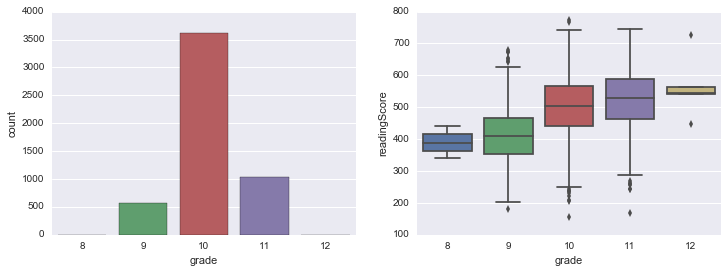

In [263]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))
sns.countplot(x='grade', data=pisa, ax=ax[0])
sns.boxplot(x='grade', y='readingScore', data=pisa, ax=ax[1])
plt.show()

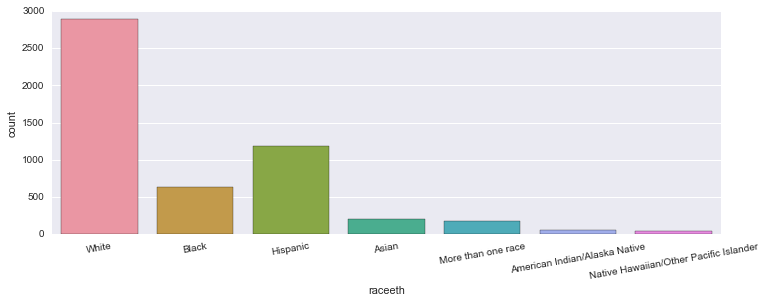

In [264]:
fig = plt.figure(figsize=(12, 4))
sns.countplot(x='raceeth', data=pisa)
a = plt.xticks(rotation = 10)

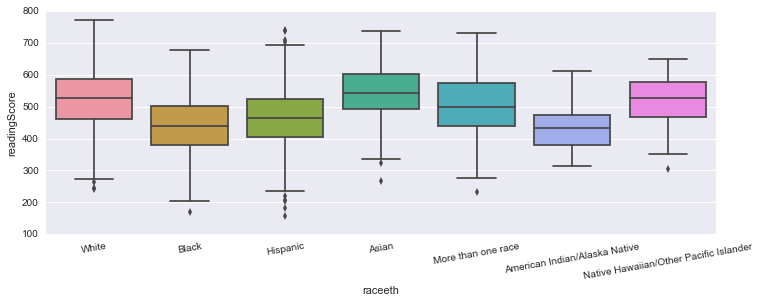

In [265]:
fig = plt.figure(figsize=(12, 4))
sns.boxplot(x='raceeth', y='readingScore', data=pisa)
x = plt.xticks(rotation = 10)
plt.show()

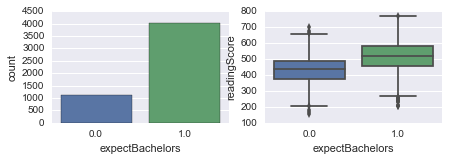

In [266]:
fig, ax = plt.subplots(1,2, figsize=(7, 2))
sns.countplot(x='expectBachelors', data=pisa, ax=ax[0])
sns.boxplot(x='expectBachelors', y='readingScore', data=pisa, ax=ax[1])
plt.show()

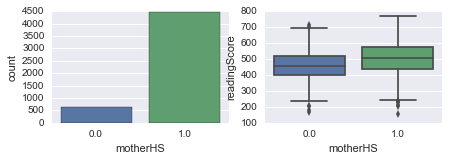

In [267]:
fig, ax = plt.subplots(1,2, figsize=(7, 2))
sns.countplot(x='motherHS', data=pisa, ax=ax[0])
sns.boxplot(x='motherHS', y='readingScore', data=pisa, ax=ax[1])
plt.show()

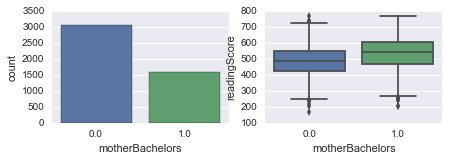

In [268]:
fig, ax = plt.subplots(1,2, figsize=(7, 2))
sns.countplot(x='motherBachelors', data=pisa, ax=ax[0])
sns.boxplot(x='motherBachelors', y='readingScore', data=pisa, ax=ax[1])
plt.show()

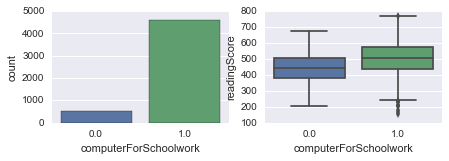

In [269]:
fig, ax = plt.subplots(1,2, figsize=(7, 2))
sns.countplot(x='computerForSchoolwork', data=pisa, ax=ax[0])
sns.boxplot(x='computerForSchoolwork', y='readingScore', data=pisa, ax=ax[1])
plt.show()

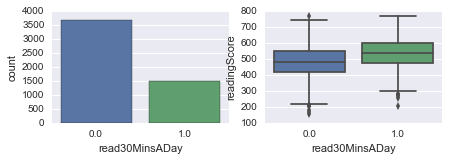

In [270]:
fig, ax = plt.subplots(1,2, figsize=(7, 2))
sns.countplot(x='read30MinsADay', data=pisa, ax=ax[0])
sns.boxplot(x='read30MinsADay', y='readingScore', data=pisa, ax=ax[1])
plt.show()

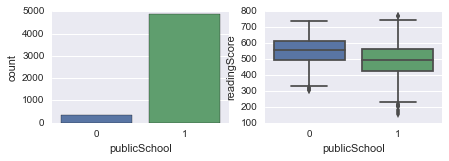

In [271]:
fig, ax = plt.subplots(1,2, figsize=(7, 2))
sns.countplot(x='publicSchool', data=pisa, ax=ax[0])
sns.boxplot(x='publicSchool', y='readingScore', data=pisa, ax=ax[1])
plt.show()

## Algorithms and Techniques

### Split into train and test sets

In [272]:
from sklearn.model_selection import train_test_split
pisa = pd.read_csv('pisa2009.csv')
X = pisa.drop('readingScore', axis=1)
y = pisa['readingScore']
del pisa
# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

## Benchmark

In [273]:
# Use average of scores as benchmark
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


from sklearn.preprocessing import LabelEncoder

X_train_bm = X_train.copy()
X_test_bm = X_test.copy()

X_train_bm = X_train_bm.drop('raceeth', axis=1)
X_test_bm = X_test_bm.drop('raceeth', axis=1)

X_train_bm = X_train_bm.apply(lambda x:x.fillna(0))
X_test_bm = X_test_bm.apply(lambda x:x.fillna(0))


model = LinearRegression()
model.fit(X_train_bm, y_train)
benchmark_rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test_bm)))
benchmark_r2 = r2_score(y_test, model.predict(X_test_bm))
print "Benchmark r2 score: %.2f" % benchmark_r2
print "Benchmark RMSE: %.2f" % benchmark_rmse

Benchmark r2 score: 0.32
Benchmark RMSE: 78.36


# 3. Methodology
## 3.1 Data Preprocessing

Merge the training and validation sets for preprocessing

In [274]:
train_size = X_train.shape[0]
pisa = pd.concat([X_train, X_test], ignore_index=True)
del X_train
del X_test

### Handling Missing Values

In [275]:
# For continuous variables replace the missing data with average of columns
pisa['minutesPerWeekEnglish'].fillna(int(pisa['minutesPerWeekEnglish'].mean()), inplace=True)
pisa['studentsInEnglish'].fillna(int(pisa['studentsInEnglish'].mean()), inplace=True)
pisa['schoolSize'].fillna(int(pisa['schoolSize'].mean()), inplace=True)

# For 'raceeth' use 'NoRace' replacement
pisa['raceeth'].fillna('NoRace', inplace=True)
# For binary variable use 0 in place of missing value
pisa = pisa.apply(lambda x:x.fillna(0))


In [276]:
pisa.columns

Index([u'grade', u'male', u'raceeth', u'preschool', u'expectBachelors',
       u'motherHS', u'motherBachelors', u'motherWork', u'fatherHS',
       u'fatherBachelors', u'fatherWork', u'selfBornUS', u'motherBornUS',
       u'fatherBornUS', u'englishAtHome', u'computerForSchoolwork',
       u'read30MinsADay', u'minutesPerWeekEnglish', u'studentsInEnglish',
       u'schoolHasLibrary', u'publicSchool', u'urban', u'schoolSize'],
      dtype='object')

### Binning Continuous Variables

#### minutesPerWeekEnglish

In [277]:

bins = [-1, 100, 200, 300, 400, 2500 ]
group_names = ['<100', '100-200', '200-300', '300-400', '400-2500']
pisa['englishBins'] = pd.cut(pisa['minutesPerWeekEnglish'], bins, labels=group_names)
pisa = pisa.drop('minutesPerWeekEnglish', axis=1)
pisa['englishBins'].value_counts()


200-300     3337
<100         518
400-2500     503
100-200      500
300-400      375
Name: englishBins, dtype: int64

#### studentsInEnglish

In [278]:
bins = [0, 10, 20, 30, 40, 50, 100 ]
group_names = ['<10', '10-20', '20-30', '30-40', '40-50', '50-100']
pisa['englishStudents'] = pd.cut(pisa['studentsInEnglish'], bins, labels=group_names)
pisa = pisa.drop('studentsInEnglish', axis=1)
pisa['englishStudents'].value_counts()

20-30     3105
10-20     1549
30-40      418
<10        116
40-50       23
50-100      22
Name: englishStudents, dtype: int64

#### schoolSize

In [279]:
bins = [0, 100, 500, 1000, 2000, 3000, 7000 ]
group_names = ['<100', '100-500', '500-1000', '1000-2000', '2000-3000', '3000-7000']
pisa['schoolBin'] = pd.cut(pisa['schoolSize'], bins, labels=group_names)
pisa = pisa.drop('schoolSize', axis=1)
pisa['schoolBin'].value_counts()

1000-2000    2096
500-1000     1251
2000-3000     843
100-500       794
3000-7000     237
<100           12
Name: schoolBin, dtype: int64

### Handling categorical variables

In [280]:
# Encode categorical data
raceeth = pd.get_dummies(pisa['raceeth'], 'raceeth')
pisa = pd.concat([pisa, raceeth], axis=1)
pisa = pisa.drop('raceeth', axis=1)

minutes = pd.get_dummies(pisa['englishBins'], 'minutes')
pisa = pd.concat([pisa, minutes], axis=1)
pisa = pisa.drop('englishBins', axis=1)

students = pd.get_dummies(pisa['englishStudents'], 'students')
pisa = pd.concat([pisa, students], axis=1)
pisa = pisa.drop('englishStudents', axis=1)

school = pd.get_dummies(pisa['schoolBin'], 'school')
pisa = pd.concat([pisa, school], axis=1)
pisa = pisa.drop('schoolBin', axis=1)

grade = pd.get_dummies(pisa['grade'], 'grade')
pisa = pd.concat([pisa, grade], axis=1)
pisa = pisa.drop('grade', axis=1)

### Handling multicolinearity

In [281]:
# remove multicolinearity marked for removal in exploration phase
pisa = pisa.drop(['motherBachelors','motherBornUS', 'fatherBornUS'], axis=1)

In [282]:
pisa.columns.values

array(['male', 'preschool', 'expectBachelors', 'motherHS', 'motherWork',
       'fatherHS', 'fatherBachelors', 'fatherWork', 'selfBornUS',
       'englishAtHome', 'computerForSchoolwork', 'read30MinsADay',
       'schoolHasLibrary', 'publicSchool', 'urban',
       'raceeth_American Indian/Alaska Native', 'raceeth_Asian',
       'raceeth_Black', 'raceeth_Hispanic', 'raceeth_More than one race',
       'raceeth_Native Hawaiian/Other Pacific Islander', 'raceeth_NoRace',
       'raceeth_White', 'minutes_<100', 'minutes_100-200',
       'minutes_200-300', 'minutes_300-400', 'minutes_400-2500',
       'students_<10', 'students_10-20', 'students_20-30',
       'students_30-40', 'students_40-50', 'students_50-100',
       'school_<100', 'school_100-500', 'school_500-1000',
       'school_1000-2000', 'school_2000-3000', 'school_3000-7000',
       'grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12'], dtype=object)

### Training Test set split

In [283]:
X_train = pisa.iloc[:train_size,:]
X_test = pisa.iloc[train_size:,:]
print X_train.shape
print X_test.shape

(3663, 45)
(1570, 45)


## 3.2 Implementation

In this section a number of algorithms will be spot checked.  

In [284]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

### Helper functions

In [285]:
def spot_check_models(models, X_train, y_train):
    '''
    Perform  10-fold cross validation on mulitple models. Prints the RMSE and R2 scores
    of each model for comparison.
    
    Arguments:
    models - list of models (tuple of model name, and model object)
    X_train - Input features
    y_train - Target values
        
    '''
    results_rmse = []
    results_r2 = []
    names = []
    print "%20s: %15s %10s" % ('Model', 'RMSE (std)', 'R2(std)' )
    for name, model in models:
        kfold = KFold(n_splits=10, random_state=7)
        cv_results = np.sqrt(-cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error'))
        cv_results_r2 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
        results_rmse.append(cv_results)
        results_r2.append(cv_results_r2)
        names.append(name)
        msg = "%20s: %7.3f (%.3f)  %7.3f (%.3f)" % \
        (name, cv_results.mean(), cv_results.std(), cv_results_r2.mean(), cv_results_r2.std())
        print(msg)

In [286]:
def test_set_validation(models, X_train, y_train, X_test, y_test):
    '''
    Train the models on training set and tests the trained models on validation data.
    
    Arguments:
    models - list of models (tuple of model name, and model object) 
    X_train - Input features from training set.
    y_train - Target values of training set.
    X_test - Input features from validation set.
    y_test - Target values of validation set.
    '''
    for name, model in models:
        model.fit(X_train, y_train)
        rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
        r2 = r2_score(y_test, model.predict(X_test))   

        print "%15s RMSE: %.2f r2 score: %.2f" % (name, rmse, r2 )

In [287]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, scoring, ylim=None):
    '''
    Generate a plot of the test and training learning curve.
    
    Arguments:
    estimator - the model used.
    title - title for the chart.
    X - Input features.
    y - Target values.
    scoring - the scoring function
    ylim - Minimum and maximum y values plotted
    '''
    plt.figure(figsize=(6,3))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)
    train_sizes = np.linspace(.1, 1.0, 10)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv,
                                                            train_sizes=train_sizes, scoring= scoring)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    
    return plt

In [288]:
models = []
models.append(('Ridge', Ridge()))
models.append(('SupprtVector', SVR(kernel='linear')))
models.append(('GradientBoost', GradientBoostingRegressor() ))
models.append(('RandomForests', RandomForestRegressor() ))
spot_check_models(models, X_train, y_train)

               Model:      RMSE (std)    R2(std)
               Ridge:  76.223 (3.725)    0.363 (0.035)
        SupprtVector:  76.372 (3.559)    0.360 (0.030)
       GradientBoost:  76.137 (3.668)    0.365 (0.031)
       RandomForests:  85.191 (2.736)    0.213 (0.056)


In [289]:
print "Benchmark r2 score: %.2f" % benchmark_r2
print "Benchmark RMSE: %.2f" % benchmark_rmse

Benchmark r2 score: 0.32
Benchmark RMSE: 78.36


### Learning curves

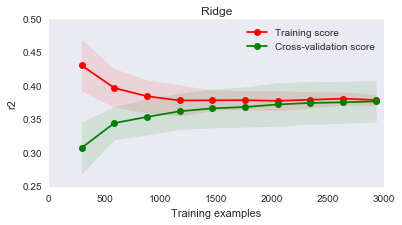

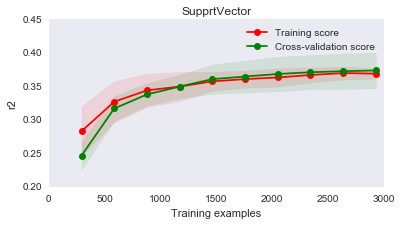

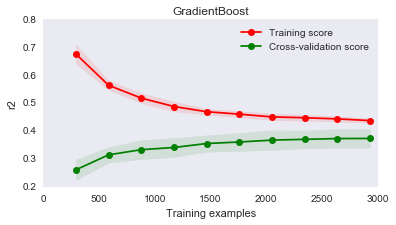

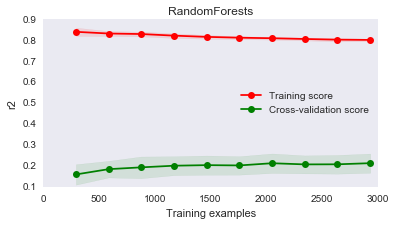

In [41]:
for name, model in models:
    plot_learning_curve(model,name, X_train, y_train, 'r2')

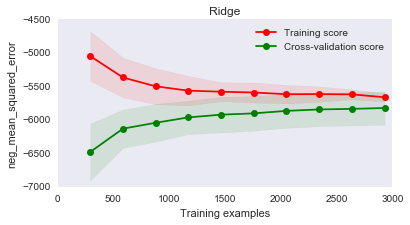

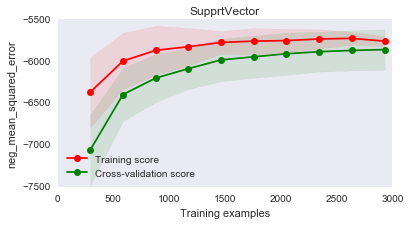

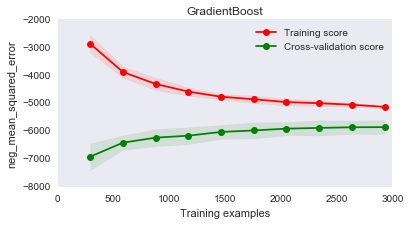

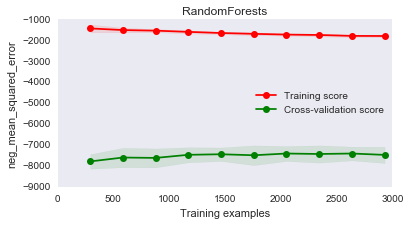

In [42]:
for name, model in models:
    plot_learning_curve(model,name, X_train, y_train, 'neg_mean_squared_error')

### Verify with test set

In [290]:
for name, model in models:
    model.fit(X_train, y_train)
    rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    r2 = r2_score(y_test, model.predict(X_test))   
           
    print "%15s RMSE: %.2f r2 score: %.2f" % (name, rmse, r2 )

print "\n"
print "Benchmark r2 score: %.2f" % benchmark_r2
print "Benchmark RMSE: %.2f" % benchmark_rmse    

          Ridge RMSE: 75.09 r2 score: 0.38
   SupprtVector RMSE: 75.12 r2 score: 0.38
  GradientBoost RMSE: 73.96 r2 score: 0.40
  RandomForests RMSE: 80.70 r2 score: 0.28


Benchmark r2 score: 0.32
Benchmark RMSE: 78.36


## 3.3 Refinement

### 3.3.1. Feature selction

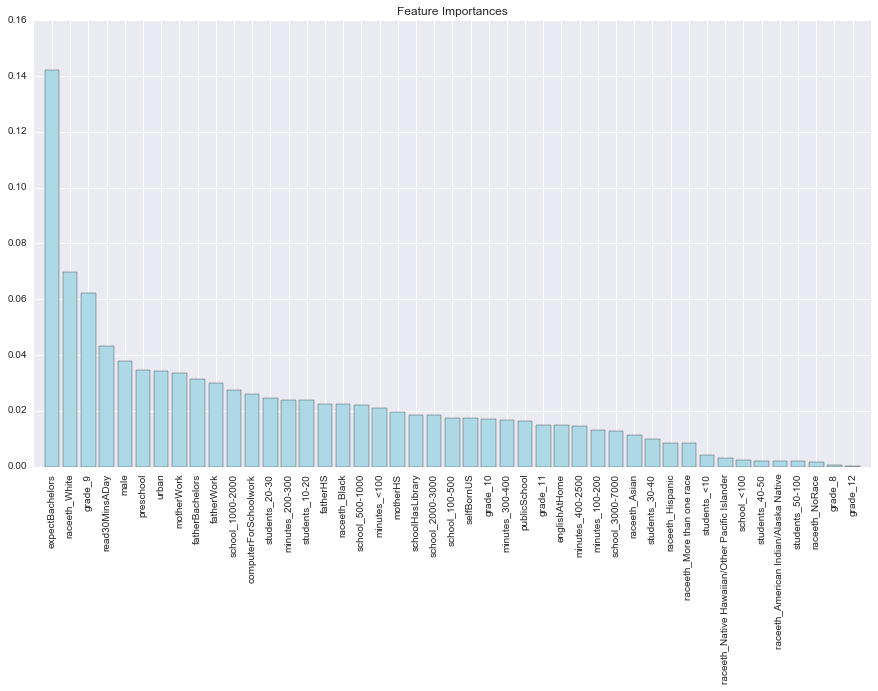

In [292]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
importances = model.feature_importances_
feat_sel_indices = np.argsort(importances)[::-1]
feature_labels = pisa.columns
labels_reordered = [feature_labels[i] for i in feat_sel_indices]
plt.figure(figsize=(15,8)) 
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[feat_sel_indices],color='lightblue', align='center')
plt.xticks(range(X_train.shape[1]), labels_reordered, rotation=90)
plt.xlim([-1, X_train.shape[1]])
#plt.tight_layout()
plt.show()

In [45]:
for n_features in range(1, len(feat_sel_indices)):
    features = feat_sel_indices[:n_features]
    model = GradientBoostingRegressor()
    kfold = KFold(n_splits=10, random_state=7)
    rmse = np.mean(np.sqrt(-cross_val_score(model, X_train[features], y_train, cv=kfold, scoring='neg_mean_squared_error')))
    r2 = np.mean(cross_val_score(model, X_train[features], y_train, cv=kfold, scoring='r2'))  
           
    print "Top %2d features RMSE: %.2f r2 score: %.2f" % (n_features, rmse, r2 )

Top  1 features RMSE: 89.29 r2 score: 0.13
Top  2 features RMSE: 85.89 r2 score: 0.19
Top  3 features RMSE: 83.01 r2 score: 0.24
Top  4 features RMSE: 81.07 r2 score: 0.28
Top  5 features RMSE: 79.98 r2 score: 0.30
Top  6 features RMSE: 79.97 r2 score: 0.30
Top  7 features RMSE: 79.59 r2 score: 0.31
Top  8 features RMSE: 79.68 r2 score: 0.30
Top  9 features RMSE: 79.64 r2 score: 0.30
Top 10 features RMSE: 79.73 r2 score: 0.30
Top 11 features RMSE: 79.15 r2 score: 0.31
Top 12 features RMSE: 79.12 r2 score: 0.31
Top 13 features RMSE: 79.13 r2 score: 0.31
Top 14 features RMSE: 79.08 r2 score: 0.31
Top 15 features RMSE: 78.82 r2 score: 0.32
Top 16 features RMSE: 78.68 r2 score: 0.32
Top 17 features RMSE: 78.07 r2 score: 0.33
Top 18 features RMSE: 78.11 r2 score: 0.33
Top 19 features RMSE: 77.96 r2 score: 0.33
Top 20 features RMSE: 77.97 r2 score: 0.33
Top 21 features RMSE: 77.57 r2 score: 0.34
Top 22 features RMSE: 77.40 r2 score: 0.34
Top 23 features RMSE: 77.46 r2 score: 0.34
Top 24 feat

In [293]:
selected_features = feat_sel_indices[:37]

In [294]:
spot_check_models(models, X_train[selected_features], y_train)

               Model:      RMSE (std)    R2(std)
               Ridge:  76.307 (3.518)    0.361 (0.033)
        SupprtVector:  76.379 (3.532)    0.360 (0.029)
       GradientBoost:  76.125 (3.539)    0.364 (0.032)
       RandomForests:  84.929 (3.058)    0.203 (0.052)


### 3.3.2 Selecting hyperparameters

In [295]:
def plot_validation_curve(estimator, X, y, param_name, param_range, 
                          scoring, plot_title, x_label, y_label, n_jobs=-1):
    '''
    Plots training and test scores for varying parameter values.
    
    Arguments:
    estimator - The model.
    X - Input features.
    y - Target values.
    param_name - Name of the parameter that will be varied.
    param_range - The values of the parameter that will be varied.
    scoring - the scoring function.
    plot_title - The title of the chart.
    x_label - Label for the x axis.
    y_label - Label for the y axis.
    n_jobs - Number of jobs to run parallel.
    '''
    cv = ShuffleSplit( test_size=0.2, random_state=7)
    
    start = timeit.default_timer()
    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range,
                                                 cv=cv, scoring=scoring, n_jobs=n_jobs)
    stop = timeit.default_timer()
    print 'Validation Curves Runtime: %d seconds' % (stop-start)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Print Scores
    for param, train_score, test_score in zip(param_range, train_scores_mean, test_scores_mean):
        print ('{0}: {1:7d}    Train Score: {2:.3f} Test Score: {3:.3f}' .format(param_name, int(param), float(train_score), float(test_score)))
    
    plt.figure(figsize=(5,3))
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.show()

In [296]:
def grid_search_validation_curve(estimator, X, y, param_name, param_value, scoring):
    '''
    Perform grid search for a  varying parameter and plots the validation curve.
    
    Arguments:
    estimator - The model.
    X - Input features.
    y - Target values.
    param_name - Name of the parameter that will be varied.
    param_range - The values of the parameter that will be varied.
    scoring - the scoring function.
    '''
    param_grid = {}
    param_grid[param_name] = param_value

    kfold = KFold(n_splits=5, random_state=7)
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid_result = grid.fit(X, y)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    #plot_validation_curve(model, X_train, y_train, param_name, param_value, 'r2',
    #                      'validation curve - '+estimator.__class__.__name__ , param_name,scoring )

In [297]:
def select_hyperparams(estimator, X_train, y_train, param_grid, scoring):
    '''
    Finds the best hyperparameters for the model using grid search with 5x2 cross validation.
    
    Arguments:
    X_train - Input features from training set.
    y_train - Target values of training set.
    estimator - The model. 
    param_grid - Dictionary containing hyperparameters and their range.
    scoring - the scoring function.
    '''
    
    start = timeit.default_timer()
   
    model_gs = GridSearchCV(estimator=estimator,param_grid=param_grid,
                  scoring=scoring, cv=2, n_jobs=-1)
   
    scores = cross_val_score(estimator=estimator, X=X_train, y=y_train,
                             scoring=scoring, cv=5)

    model_gs = model_gs.fit(X=X_train, y=y_train)
    
    stop = timeit.default_timer()
    print 'GridSearchCV Runtime: %d seconds' % (stop-start)
    print '\n'
    print 'All CV Scores:', scores
    print('Mean CV Score: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
    print 'Best Estimator:\n', model_gs.best_estimator_

#### Hyperparameters for Gradient Boosting Regressor
* learning_rate
* n_estimators
* max_depth
* min_samples_split
* min_samples_leaf
* subsample

In [298]:
learning_rate = [0.01,0.1,0.15,0.2,0.3,0.35,0.4,0.5,0.6,0.7]
model = GradientBoostingRegressor(random_state=7)
grid_search_validation_curve(model, X_train[selected_features], y_train, param_name='learning_rate',
                             param_value=learning_rate, scoring='r2')

Best: 0.365655 using {'learning_rate': 0.1}
0.238087 (0.008720) with: {'learning_rate': 0.01}
0.365655 (0.027489) with: {'learning_rate': 0.1}
0.361940 (0.027825) with: {'learning_rate': 0.15}
0.356861 (0.027290) with: {'learning_rate': 0.2}
0.345502 (0.025387) with: {'learning_rate': 0.3}
0.335008 (0.026196) with: {'learning_rate': 0.35}
0.331970 (0.032272) with: {'learning_rate': 0.4}
0.309800 (0.027466) with: {'learning_rate': 0.5}
0.291889 (0.030113) with: {'learning_rate': 0.6}
0.285110 (0.030805) with: {'learning_rate': 0.7}


In [299]:
n_estimators = range(50, 600, 50)
model = GradientBoostingRegressor(learning_rate=0.1, random_state=7)
grid_search_validation_curve(model, X_train[selected_features], y_train, param_name='n_estimators', param_value=n_estimators, scoring='r2')

Best: 0.365655 using {'n_estimators': 100}
0.356810 (0.023667) with: {'n_estimators': 50}
0.365655 (0.027489) with: {'n_estimators': 100}
0.364870 (0.027380) with: {'n_estimators': 150}
0.362271 (0.026463) with: {'n_estimators': 200}
0.357019 (0.027124) with: {'n_estimators': 250}
0.349371 (0.027230) with: {'n_estimators': 300}
0.344723 (0.027027) with: {'n_estimators': 350}
0.341670 (0.028521) with: {'n_estimators': 400}
0.337145 (0.029534) with: {'n_estimators': 450}
0.334357 (0.029572) with: {'n_estimators': 500}
0.331106 (0.030135) with: {'n_estimators': 550}


In [303]:
max_depth = range(1, 11)
model = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, random_state=7)
grid_search_validation_curve(model, X_train[selected_features], y_train, param_name='max_depth', param_value=max_depth, scoring='r2')

Best: 0.365655 using {'max_depth': 3}
0.341669 (0.019030) with: {'max_depth': 1}
0.362355 (0.024578) with: {'max_depth': 2}
0.365655 (0.027489) with: {'max_depth': 3}
0.352848 (0.030931) with: {'max_depth': 4}
0.334506 (0.030742) with: {'max_depth': 5}
0.302828 (0.041370) with: {'max_depth': 6}
0.276553 (0.043442) with: {'max_depth': 7}
0.242666 (0.051619) with: {'max_depth': 8}
0.191006 (0.044890) with: {'max_depth': 9}
0.145656 (0.064714) with: {'max_depth': 10}


In [304]:
min_samples_split = [1,3,4,5,6,7,8,9,10,15,20,30]
model = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100,max_depth=3, random_state=7)
grid_search_validation_curve(model, X_train[selected_features], y_train,
                             param_name='min_samples_split', param_value=min_samples_split, scoring='r2')

Best: 0.367344 using {'min_samples_split': 15}
0.365655 (0.027489) with: {'min_samples_split': 1}
0.365655 (0.027489) with: {'min_samples_split': 3}
0.365655 (0.027489) with: {'min_samples_split': 4}
0.365820 (0.027325) with: {'min_samples_split': 5}
0.365820 (0.027325) with: {'min_samples_split': 6}
0.365799 (0.027342) with: {'min_samples_split': 7}
0.365777 (0.027353) with: {'min_samples_split': 8}
0.365753 (0.027312) with: {'min_samples_split': 9}
0.366390 (0.026712) with: {'min_samples_split': 10}
0.367344 (0.025710) with: {'min_samples_split': 15}
0.366204 (0.026031) with: {'min_samples_split': 20}
0.366288 (0.027787) with: {'min_samples_split': 30}


In [305]:
min_samples_leaf = [1,2,3,4,5,7]
model = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=15, random_state=7)
grid_search_validation_curve(model, X_train[selected_features], y_train, param_name='min_samples_leaf',
                             param_value=min_samples_leaf, scoring='r2')

Best: 0.368621 using {'min_samples_leaf': 5}
0.367344 (0.025710) with: {'min_samples_leaf': 1}
0.366808 (0.026299) with: {'min_samples_leaf': 2}
0.367152 (0.026824) with: {'min_samples_leaf': 3}
0.366926 (0.026440) with: {'min_samples_leaf': 4}
0.368621 (0.025782) with: {'min_samples_leaf': 5}
0.367703 (0.025285) with: {'min_samples_leaf': 7}


In [306]:
subsample = [0.1,0.3,0.5,0.6,0.7,0.75,0.8,0.9,1.0]
model = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3, min_samples_split=15,
                                  min_samples_leaf=5, random_state=7)
grid_search_validation_curve(model, X_train[selected_features], y_train, param_name='subsample',
                             param_value=subsample, scoring='r2')

Best: 0.369031 using {'subsample': 0.8}
0.343285 (0.029574) with: {'subsample': 0.1}
0.359819 (0.025314) with: {'subsample': 0.3}
0.363611 (0.029618) with: {'subsample': 0.5}
0.368403 (0.028297) with: {'subsample': 0.6}
0.368947 (0.025265) with: {'subsample': 0.7}
0.368366 (0.028015) with: {'subsample': 0.75}
0.369031 (0.028248) with: {'subsample': 0.8}
0.368256 (0.026698) with: {'subsample': 0.9}
0.368621 (0.025782) with: {'subsample': 1.0}


In [321]:
param_grid = {'learning_rate'     : [0.1, 0.15],
              'n_estimators'      : [100, 150,200],
              'max_features'      : ['auto','sqrt','log2'],
              'max_depth'         : [1,2,3,4],
              'min_samples_split' : [13,14,15,16,17],
              'min_samples_leaf'  : [4,5,7],
              'subsample'         : [0.8, 0.9, 1.0],
              'random_state'      : [7]}

model = GradientBoostingRegressor()
select_hyperparams(model, X_train[selected_features], y_train, param_grid, 'r2')

GridSearchCV Runtime: 492 seconds


All CV Scores: [ 0.38123591  0.34474907  0.35185069  0.41211941  0.33813489]
Mean CV Score: 0.366 +/- 0.028
Best Estimator:
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3,
             max_features='log2', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=4,
             min_samples_split=16, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=7,
             subsample=0.9, verbose=0, warm_start=False)


#### Hyperparameters for Support Vector Regressor
* C
* epsilon

In [308]:
model = SVR(kernel='linear')
C = [1, 2, 3, 4, 5]
grid_search_validation_curve(model, X_train[selected_features], y_train, param_name='C', param_value=C, scoring='r2')

Best: 0.361635 using {'C': 3}
0.360274 (0.025480) with: {'C': 1}
0.361215 (0.028143) with: {'C': 2}
0.361635 (0.029627) with: {'C': 3}
0.361589 (0.030238) with: {'C': 4}
0.361045 (0.030848) with: {'C': 5}


Lets keep 1, 2, 3 and 4 for hyperparameter tuning

In [311]:
#epsilon = np.logspace(-1,1,10)
epsilon = range(14, 20)
model = SVR(kernel='linear', C=3)
grid_search_validation_curve(model, X_train[selected_features], y_train, param_name='epsilon', param_value=epsilon, scoring='r2')

Best: 0.364421 using {'epsilon': 16}
0.364290 (0.030487) with: {'epsilon': 14}
0.364071 (0.030147) with: {'epsilon': 15}
0.364421 (0.030039) with: {'epsilon': 16}
0.364143 (0.030004) with: {'epsilon': 17}
0.363970 (0.029936) with: {'epsilon': 18}
0.364155 (0.029888) with: {'epsilon': 19}


Use 1.1, 1.2.1.3, 1.4 

In [312]:
param_grid = {'kernel' : ['linear', 'rbf'],
              'C'      : [1, 2, 3],
              'epsilon': [ 15, 16, 17, 18]
              }

model = SVR()
select_hyperparams(model, X_train[selected_features], y_train, param_grid, 'r2')

GridSearchCV Runtime: 18 seconds


All CV Scores: [ 0.15908564  0.15424268  0.15311909  0.1641301   0.1585057 ]
Mean CV Score: 0.158 +/- 0.004
Best Estimator:
SVR(C=3, cache_size=200, coef0=0.0, degree=3, epsilon=18, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


#### Hyperparameters for Ridge
* alpha

In [313]:
model = Ridge()
alpha = range(1,30,2)
grid_search_validation_curve(model, X_train[selected_features], y_train,
                             param_name='alpha', param_value=alpha, scoring='r2')

Best: 0.362674 using {'alpha': 25}
0.361615 (0.030300) with: {'alpha': 1}
0.361903 (0.030033) with: {'alpha': 3}
0.362085 (0.029742) with: {'alpha': 5}
0.362222 (0.029475) with: {'alpha': 7}
0.362331 (0.029227) with: {'alpha': 9}
0.362419 (0.028995) with: {'alpha': 11}
0.362491 (0.028774) with: {'alpha': 13}
0.362549 (0.028564) with: {'alpha': 15}
0.362594 (0.028362) with: {'alpha': 17}
0.362629 (0.028167) with: {'alpha': 19}
0.362653 (0.027978) with: {'alpha': 21}
0.362668 (0.027795) with: {'alpha': 23}
0.362674 (0.027617) with: {'alpha': 25}
0.362672 (0.027444) with: {'alpha': 27}
0.362662 (0.027276) with: {'alpha': 29}


#### Hyperparameters for Random Forest Regressor
* n_estimators
* max_features
* max_depth
* min_samples_split
* min_samples_leaf

In [314]:
n_estimators = range(50, 600, 50)
model = RandomForestRegressor(random_state=7)
grid_search_validation_curve(model, X_train[selected_features], y_train,
                             param_name='n_estimators', param_value=n_estimators, scoring='r2')

Best: 0.253617 using {'n_estimators': 250}
0.242125 (0.037291) with: {'n_estimators': 50}
0.248901 (0.036863) with: {'n_estimators': 100}
0.252089 (0.034778) with: {'n_estimators': 150}
0.253452 (0.035832) with: {'n_estimators': 200}
0.253617 (0.035839) with: {'n_estimators': 250}
0.253153 (0.035224) with: {'n_estimators': 300}
0.253205 (0.035743) with: {'n_estimators': 350}
0.253040 (0.035413) with: {'n_estimators': 400}
0.252725 (0.034812) with: {'n_estimators': 450}
0.253551 (0.034643) with: {'n_estimators': 500}
0.253486 (0.034237) with: {'n_estimators': 550}


In [315]:
max_depth = range(1, 11)
model = RandomForestRegressor(n_estimators=250, random_state=7)
grid_search_validation_curve(model, X_train[selected_features], y_train,
                             param_name='max_depth', param_value=max_depth, scoring='r2')

Best: 0.334270 using {'max_depth': 7}
0.128563 (0.024673) with: {'max_depth': 1}
0.222226 (0.019833) with: {'max_depth': 2}
0.269316 (0.019613) with: {'max_depth': 3}
0.297341 (0.019416) with: {'max_depth': 4}
0.315243 (0.021006) with: {'max_depth': 5}
0.327883 (0.024206) with: {'max_depth': 6}
0.334270 (0.026160) with: {'max_depth': 7}
0.333634 (0.027769) with: {'max_depth': 8}
0.331104 (0.028174) with: {'max_depth': 9}
0.325688 (0.028511) with: {'max_depth': 10}


In [316]:
min_samples_split = [1,3,4,5,6,7,8,9,10,15,20,30]
model = RandomForestRegressor(n_estimators=250, max_depth=7, random_state=7)
grid_search_validation_curve(model, X_train[selected_features], y_train,
                             param_name='min_samples_split', param_value=min_samples_split, scoring='r2')

Best: 0.335390 using {'min_samples_split': 20}
0.334270 (0.026160) with: {'min_samples_split': 1}
0.334117 (0.025957) with: {'min_samples_split': 3}
0.334055 (0.025937) with: {'min_samples_split': 4}
0.334240 (0.025928) with: {'min_samples_split': 5}
0.334141 (0.025696) with: {'min_samples_split': 6}
0.334495 (0.025599) with: {'min_samples_split': 7}
0.334634 (0.025658) with: {'min_samples_split': 8}
0.334654 (0.025479) with: {'min_samples_split': 9}
0.334720 (0.025313) with: {'min_samples_split': 10}
0.335007 (0.024968) with: {'min_samples_split': 15}
0.335390 (0.023950) with: {'min_samples_split': 20}
0.335135 (0.022592) with: {'min_samples_split': 30}


In [317]:
min_samples_leaf = range(1, 11)
model = RandomForestRegressor(n_estimators=250,  max_depth=7, min_samples_split=20, random_state=7)
grid_search_validation_curve(model, X_train[selected_features], y_train,
                             param_name='min_samples_leaf', param_value=min_samples_leaf, scoring='r2')

Best: 0.335595 using {'min_samples_leaf': 2}
0.335390 (0.023950) with: {'min_samples_leaf': 1}
0.335595 (0.023675) with: {'min_samples_leaf': 2}
0.335481 (0.023986) with: {'min_samples_leaf': 3}
0.335210 (0.024510) with: {'min_samples_leaf': 4}
0.334872 (0.024727) with: {'min_samples_leaf': 5}
0.334629 (0.024417) with: {'min_samples_leaf': 6}
0.334297 (0.024609) with: {'min_samples_leaf': 7}
0.333802 (0.024172) with: {'min_samples_leaf': 8}
0.333488 (0.024198) with: {'min_samples_leaf': 9}
0.333125 (0.024221) with: {'min_samples_leaf': 10}


In [320]:
param_grid = {'n_estimators'      : [250],
              'max_depth'         : [6, 7,8],
              'min_samples_split' : [19,20,21,22],
              'min_samples_leaf'  : [1,2,3],
              'max_features'      : ['auto','sqrt','log2'],
              'random_state'      : [7]}

model = RandomForestRegressor()
select_hyperparams(model, X_train[selected_features], y_train, param_grid, 'r2')

GridSearchCV Runtime: 124 seconds


All CV Scores: [ 0.20462034  0.15474346  0.21266443  0.26713491  0.16657658]
Mean CV Score: 0.201 +/- 0.040
Best Estimator:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=21, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)


# 4. Results

## 4.1 Model Evaluation and Validation

### 4.1.1 Validatiing with unseen data

All CV Scores: [ 0.38123591  0.34474907  0.35185069  0.41211941  0.33813489]
Mean CV Score: 0.366 +/- 0.028
Best Estimator:
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3,
             max_features='log2', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=4,
             min_samples_split=16, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=7,
             subsample=0.9, verbose=0, warm_start=False)

All CV Scores: [ 0.15908564  0.15424268  0.15311909  0.1641301   0.1585057 ]
Mean CV Score: 0.158 +/- 0.004
Best Estimator:
SVR(C=3, cache_size=200, coef0=0.0, degree=3, epsilon=18, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


Ridge
Best: 0.362674 using {'alpha': 25}



In [322]:
tuned_models = []
tuned_models.append(('GradientBoost',GradientBoostingRegressor(learning_rate=0.1, max_depth=3, max_features='log2',
                                 min_samples_leaf=4, n_estimators=100, random_state=7, subsample=0.9)))
tuned_models.append(('Ridge',Ridge(alpha=25)))
tuned_models.append(('SVR',SVR(C=3, kernel='linear', epsilon=18)))
tuned_models.append(('RandomForest',RandomForestRegressor(max_depth=8, max_features='sqrt',
                                 min_samples_leaf=1, min_samples_split=3, n_estimators=550, random_state=7)))


test_set_validation(tuned_models, X_train[selected_features], y_train, X_test[selected_features], y_test)

print "Benchmark r2 score: %.2f" % benchmark_r2
print "Benchmark RMSE: %.2f" % benchmark_rmse

  GradientBoost RMSE: 74.08 r2 score: 0.39
          Ridge RMSE: 74.94 r2 score: 0.38
            SVR RMSE: 75.03 r2 score: 0.38
   RandomForest RMSE: 75.36 r2 score: 0.37
Benchmark r2 score: 0.32
Benchmark RMSE: 78.36


Among the four tuned algorithms GradientBoost got best score. Other algorithms also scored closer.
The RMSE got improved from 78.36 to 74.08. The R2 got improved from 0.32 to 0.39. 

### 4.1.2 Generalization of the final model

<module 'matplotlib.pyplot' from 'C:\Users\Shinto\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

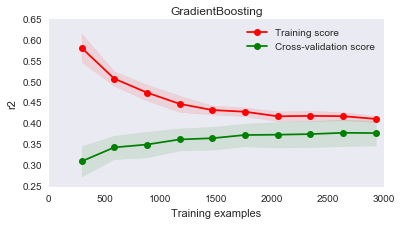

In [326]:
final_model = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, max_features='log2',
                                 min_samples_leaf=4, n_estimators=100, random_state=7, subsample=0.9)

plot_learning_curve(final_model,'GradientBoosting', X_train[selected_features], y_train, scoring='r2')

<module 'matplotlib.pyplot' from 'C:\Users\Shinto\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

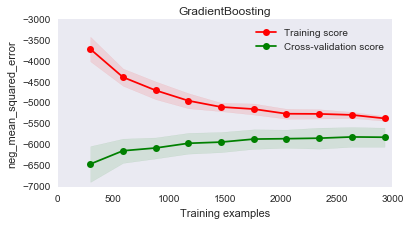

In [327]:
plot_learning_curve(final_model,'GradientBoosting', X_train[selected_features], y_train, scoring='neg_mean_squared_error')

## 4.2 Justification

The results are better than the benchmark result reported earlier
Analyze and discuss the final solutions
Is the final solution significant enough to have solved the problem? No.

# 5. Conclusion

## 5.1 Free-Form Visualization

### Residual plot 

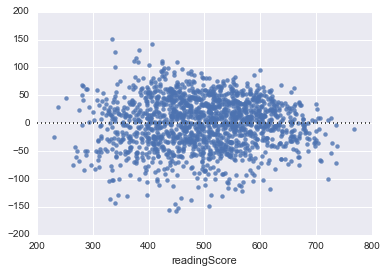

In [352]:
final_model.fit(X_train[selected_features], y_train)
test_pred = final_model.predict(X_test[selected_features])
sns.residplot(y_test, test_pred)

The above residual plot shows residuals on the vertical axis and the target variable, readingScore on the horizontal axis. The above residual plot shows a random pattern. A line of best fit is a good approximation of the data.

### Actual vs Predicted Plot

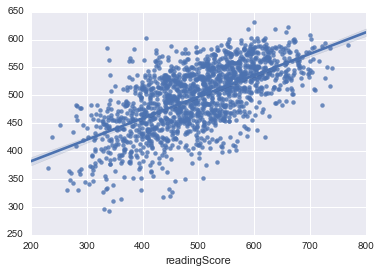

In [336]:
sns.regplot(y_test, test_pred)

Scatter plots of Actual Vs Predicted are useful in analyzing the performance of the model. Ideally, all points should be close to a regressed diagonal line. 

## 5.2 Reflection

## 5.3 Improvement

### Ensemble of GradientBoost, SVR, Ridge and RandomForest

In [339]:
model_gbm = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, max_features='log2',
                                 min_samples_leaf=4, n_estimators=100, random_state=7, subsample=0.9)
model_ridge = Ridge(alpha=25)
model_svr = SVR(C=3, kernel='linear', epsilon=18)
model_rf = RandomForestRegressor(max_depth=8, max_features='sqrt',
                                 min_samples_leaf=1, min_samples_split=3, n_estimators=550, random_state=7)

model_gbm.fit(X_train, y_train)
model_ridge.fit(X_train, y_train)
model_svr.fit(X_train, y_train)
model_rf.fit(X_train, y_train)

0.391044639982


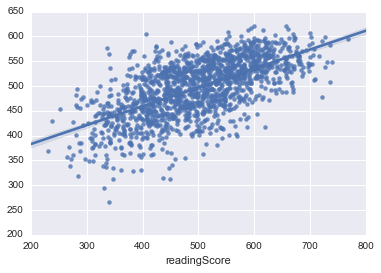

In [344]:
ensemble_pred = model_gbm.predict(X_test)
print r2_score(y_test, ensemble_pred)
sns.regplot(y_test, ensemble_pred)

0.387317986975


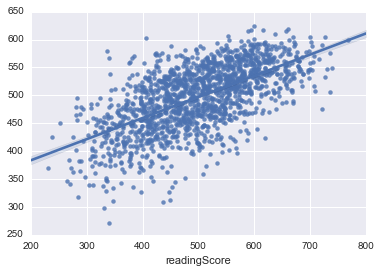

In [346]:
ensemble_pred = (model_gbm.predict(X_test) + model_ridge.predict(X_test))/2
print r2_score(y_test, ensemble_pred)
sns.regplot(y_test, ensemble_pred)

0.384852653737


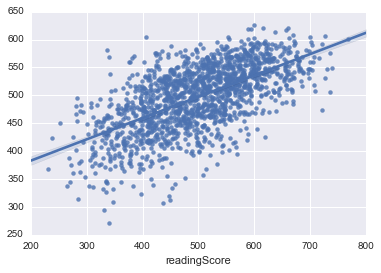

In [347]:
ensemble_pred = (model_gbm.predict(X_test) + model_ridge.predict(X_test) + model_svr.predict(X_test))/3
print r2_score(y_test, ensemble_pred)
sns.regplot(y_test, ensemble_pred)

0.385207486738


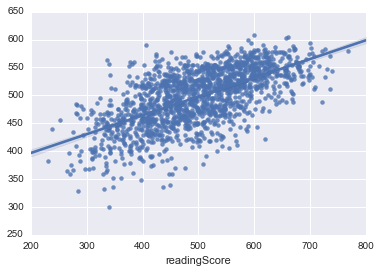

In [349]:
ensemble_pred = (model_gbm.predict(X_test) + model_rf.predict(X_test))/2
print r2_score(y_test, ensemble_pred)
sns.regplot(y_test, ensemble_pred)

(array([   2.,   10.,   29.,   81.,  178.,  289.,  290.,  404.,  238.,   49.]),
 array([ 266.51546432,  302.04489343,  337.57432255,  373.10375167,
         408.63318078,  444.1626099 ,  479.69203902,  515.22146813,
         550.75089725,  586.28032637,  621.80975548]),
 <a list of 10 Patch objects>)

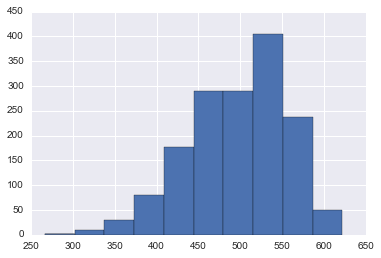

In [350]:
plt.hist(model_gbm.predict(X_test))

(array([  15.,   65.,  137.,  269.,  307.,  313.,  264.,  134.,   56.,   10.]),
 array([ 230.93 ,  284.638,  338.346,  392.054,  445.762,  499.47 ,
         553.178,  606.886,  660.594,  714.302,  768.01 ]),
 <a list of 10 Patch objects>)

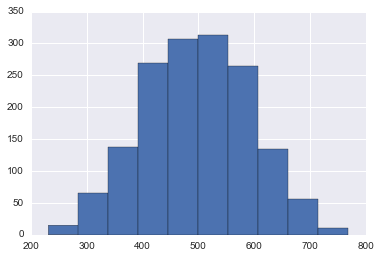

In [351]:
plt.hist(y_test)